In [1]:
# Importanweisungen
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.axes as axes
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches
import itertools
import math
import numpy as np
import statistics as stat
import scipy as sci
from scipy import optimize
import uncertainties as unc
import uncertainties.unumpy as unp
import uncertainties.umath as umath
import pandas as pd

unv=unp.nominal_values
usd=unp.std_devs

In [2]:
# Konstanten fuer einheitliche Darstellung

sidescreen = (8, 6)
fullscreen = (10,6)
widescreen = (16,6)
fig_size = fullscreen
fig_legendsize = 14
fig_labelsize = 12
matplotlib.rcParams.update({'font.size': fig_labelsize})

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [3]:
# allgemeine Fitfunktionen

def const(x,c):
    return c

def linear(x,m): # lineare Funktion mit f(x) = m * x 
    return(m*x)

def gerade(x, m, b): # gerade mit = f(x) = m * x + b
    return (m*x + b)

def cyclic(x, a, f, phi):
    return a * np.sin(x * f - phi)

def cyclicOff(x, a, f, phi, offset):
    return cyclic(x, a, f, phi) + offset

def gaussOff(x, x0, A, d, y0):
    return A * np.exp(-(x - x0)**2 / 2 / d**2) + y0

def gauss(x, A, x0, d):
    return A * np.exp(-(x-x0)**2 / 2 / d**2)

def lorentz(x, x0, A, d):
    return A / ( (x**2-x0**2)**2 + d**2 * x0**2 )

def exponential(x, c, y0):
    return np.exp(c * x) * y0

def ausbreitung(x, x0, A, g):
    return A / (x-x0)**g

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit(datax, datay, function, p0=None, yerr=None, **kwargs):
    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return pfit_curvefit, perr_curvefit

# usage zB:
# p = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [1, 0])
# fuer eine gerade mit anfangswerten m = 1, b = 0

In [4]:
# gibt Daten fuer LaTeX bereitgestellt aus

def latex_printValue(val, file):
    if hasattr(val, "__iter__"):
        i = 1
        for v in val:
            latex_printValue(v, file+"_"+str(i))
            i += 1
    else:
        f = open('data/%s.txt' % file, 'w')
        f.write(str(val).replace('/', ''))
                
def latex_printSI(val, unit, file):
    if hasattr(val, "__iter__"):
        i = 1
        for v in val:
            latex_printSI(v, unit, file+"_"+str(i))
            i += 1
    else:
        latex_printSIone(val, unit, file)

def latex_printSIone(val, unit, file):
    f = open('data/SI%s.txt' % file, 'w')
    f.write("\\SI{%s}{%s}" % (str(val).replace('/', '').replace('(', '').replace(')', ''), unit))
    
def print_latex(df):
    out="\\begin{tabular}{" + " | ".join(["r"] * len(df.columns)) + "}\n"
    out=out+" & ".join(df.keys())+"\\\\ \\hline \n"
    for i, row in df.iterrows():
        out=out+" & ".join(["$"+str(x)+"$" for x in row.values]) + " \\\\\n"
    out=out+"\\end{tabular}"
    out=out.replace("+/-","\\pm").replace(".",",").replace("$$","$")
    return out

In [5]:
# weitere Werte, Konstanten
# Werte von https://physics.nist.gov/cuu/Constants/index.html[0]

c = 299792458 # m/s
k_B = unc.ufloat_fromstr("1.38064852(79)e-23") # J K-1 [0]
h = unc.ufloat_fromstr("4.135667662(25)e-15") # eV s [0]
r_e = unc.ufloat_fromstr("2.8179403227(19)e-15") # m [0]
R = unc.ufloat_fromstr("8.3144598(48)") # J mol-1 K-1 [0]
K = 273.15 # kelvin 
eps_0 = 8.854187817e-12 # F m-1 = s4 A2 m-3 kg-1
F = 96485.33289 # Faraday konstante; coulomb per mol
Av = 6.02214076e23 # Avogadro-Konstante; n per 1 mol
g = 9.81 # m/s^2
rad = 360 / 2 / math.pi
grad = 1/rad
terra = 1e12
giga = 1e9
mega = 1e6
kilo = 1e3
dezi = 0.1
centi = 0.01
milli = 1e-3
micro = 1e-6
nano = 1e-9
pico = 1e-12
femto = 1e-15

In [6]:
# import der daten

unc_Egy = 0.0001
unc_fr = 0.005

data = np.loadtxt("../raw/faraday_rot/WS2.dat", unpack=True, delimiter="\t", skiprows=1)
ws2_Egy = np.array(data[0])
ws2_fr_250mT = np.array(data[2])
ws2_fr_500mT = np.array(data[4])
ws2_fr_750mT = np.array(data[6])
ws2_fr_1000mT = np.array(data[8])
ws2_fr_1200mT = np.array(data[10])
ws2_fr_1400mT = np.array(data[12])
xdataWS2 = unp.uarray(ws2_Egy,unc_Egy)
ydataWS2_250mT = unp.uarray(ws2_fr_250mT,unc_fr)
ydataWS2_500mT = unp.uarray(ws2_fr_500mT,unc_fr)
ydataWS2_750mT = unp.uarray(ws2_fr_750mT,unc_fr)
ydataWS2_1000mT = unp.uarray(ws2_fr_1000mT,unc_fr)
ydataWS2_1200mT = unp.uarray(ws2_fr_1200mT,unc_fr)
ydataWS2_1400mT = unp.uarray(ws2_fr_1400mT,unc_fr)

data = np.loadtxt("../raw/faraday_rot/Sapphire.dat", unpack=True, delimiter="\t", skiprows=1)
sap_Egy = np.array(data[0])
sap_fr_250mT = np.array(data[1])
sap_fr_500mT = np.array(data[2])
sap_fr_750mT = np.array(data[3])
sap_fr_1000mT = np.array(data[4])
sap_fr_1200mT = np.array(data[5])
sap_fr_1400mT = np.array(data[6])
xdataSap = unp.uarray(sap_Egy,unc_Egy)
ydataSap_250mT = unp.uarray(sap_fr_250mT,unc_fr)
ydataSap_500mT = unp.uarray(sap_fr_500mT,unc_fr)
ydataSap_750mT = unp.uarray(sap_fr_750mT,unc_fr)
ydataSap_1000mT = unp.uarray(sap_fr_1000mT,unc_fr)
ydataSap_1200mT = unp.uarray(sap_fr_1200mT,unc_fr)
ydataSap_1400mT = unp.uarray(sap_fr_1400mT,unc_fr)

#print(unv(xdataCu))
#print(unv(ydataCu))
#print(usd(ydataCu))

print(unc_Egy)

0.0001


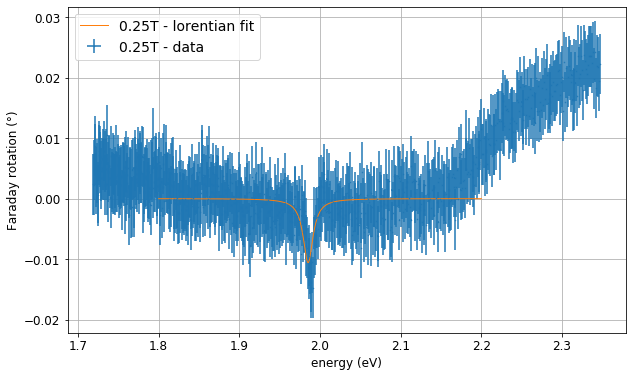

[1.9852333873557984+/-0.005123385034997739
 -9.29667840122089e-06+/-6.247675853417735e-06
 0.014929355346873827+/-0.007105897774836125]


In [7]:
#setup WS2 0.25T

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()

#Datenpunkte
plt.errorbar(unv(xdataWS2), unv(ydataWS2_250mT), usd(ydataWS2_250mT), usd(xdataWS2), label="0.25T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataWS2), unv(ydataWS2_250mT), lorentz, yerr = usd(ydataWS2_250mT), p0 = [2.02,-0.02,0.005])
l1 = unp.uarray(pfit, perr)
xfit = np.linspace(1.8, 2.2, 1000)
yfit = lorentz(xfit, *unv(l1))
plt.plot(xfit, unv(yfit) , linewidth = 1, label="0.25T - lorentian fit")
min1 = min( lorentz(xfit, *unv(l1)) )
pos1 = l1[0]

# fig param

plt.grid()
plt.xlabel("energy (eV)")
plt.ylabel("Faraday rotation (°)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/WS2_250mT.pdf")
plt.show()

print(l1)

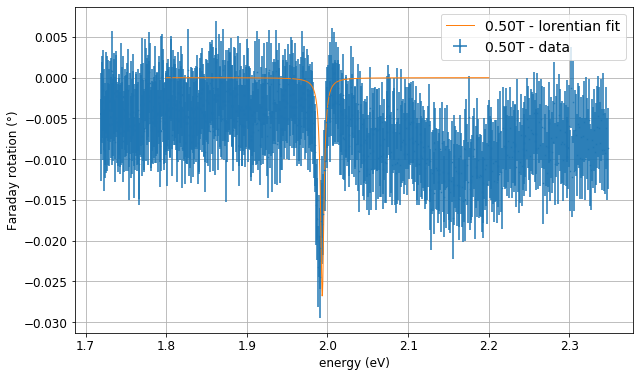

In [8]:
#setup WS2 1.4T

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()

#Datenpunkte
plt.errorbar(unv(xdataWS2), unv(ydataWS2_500mT), usd(ydataWS2_500mT), usd(xdataWS2), label="0.50T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataWS2), unv(ydataWS2_500mT), lorentz, yerr = usd(ydataWS2_500mT), p0 = [1.98,-0.5,0.001])
l2 = unp.uarray(pfit, perr)
xfit = np.linspace(1.8, 2.2, 1000)
yfit = lorentz(xfit, *unv(l2))
plt.plot(xfit, unv(yfit) , linewidth = 1, label="0.50T - lorentian fit")
min2 = min( lorentz(xfit, *unv(l2)) )
pos2 = l2[0]

# fig param

plt.grid()
plt.xlabel("energy (eV)")
plt.ylabel("Faraday rotation (°)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/WS2_500mT.pdf")
plt.show()

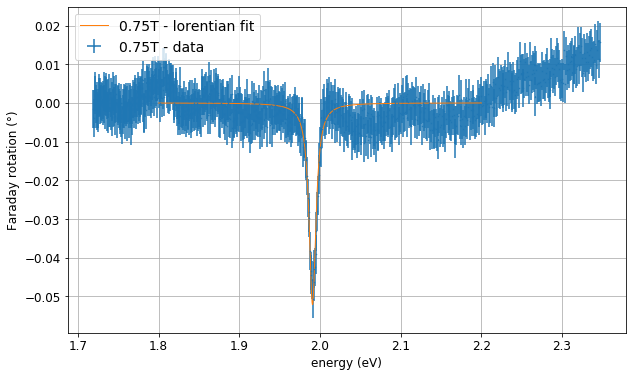

In [9]:
#setup WS2 0.75T

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()

#Datenpunkte
plt.errorbar(unv(xdataWS2), unv(ydataWS2_750mT), usd(ydataWS2_750mT), usd(xdataWS2), label="0.75T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataWS2), unv(ydataWS2_750mT), lorentz, yerr = usd(ydataWS2_750mT), p0 = [1.9925,-0.01,0.005])
l3 = unp.uarray(pfit, perr)
xfit = np.linspace(1.8, 2.2, 1000)
yfit = lorentz(xfit, *unv(l3))
plt.plot(xfit, unv(yfit) , linewidth = 1, label="0.75T - lorentian fit")
min3 = min( lorentz(xfit, *unv(l3)) )
pos3 = l3[0]

# fig param

plt.grid()
plt.xlabel("energy (eV)")
plt.ylabel("Faraday rotation (°)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/WS2_750mT.pdf")
plt.show()

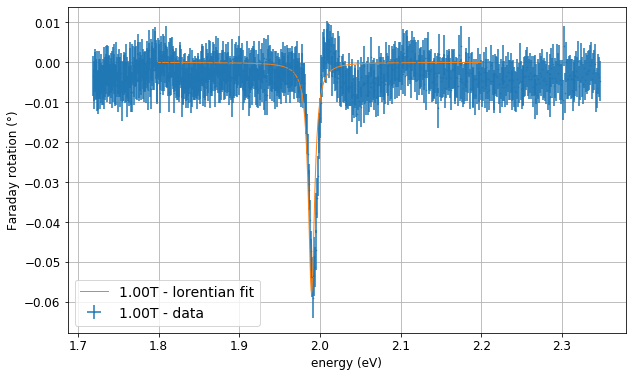

In [10]:
#setup WS2 1.0T

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()

#Datenpunkte
plt.errorbar(unv(xdataWS2), unv(ydataWS2_1000mT), usd(ydataWS2_1000mT), usd(xdataWS2), label="1.00T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataWS2), unv(ydataWS2_1000mT), lorentz, yerr = usd(ydataWS2_1000mT), p0 = [1.9925,-0.01,0.005])
l4 = unp.uarray(pfit, perr)
xfit = np.linspace(1.8, 2.2, 1000)
yfit = lorentz(xfit, *unv(l4))
plt.plot(xfit, unv(yfit) , linewidth = 1, label="1.00T - lorentian fit")
min4 = min( lorentz(xfit, *unv(l4)) )
pos4 = l4[0]

# fig param

plt.grid()
plt.xlabel("energy (eV)")
plt.ylabel("Faraday rotation (°)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/WS2_1000mT.pdf")
plt.show()

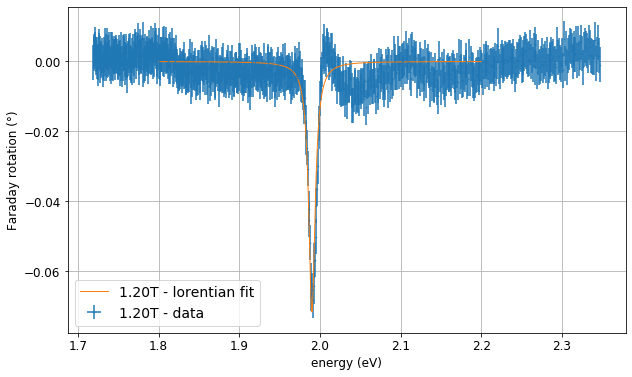

In [11]:
#setup WS2 1.2T

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()

#Datenpunkte
plt.errorbar(unv(xdataWS2), unv(ydataWS2_1200mT), usd(ydataWS2_1200mT), usd(xdataWS2), label="1.20T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataWS2), unv(ydataWS2_1200mT), lorentz, yerr = usd(ydataWS2_1200mT), p0 = [1.9925,-0.01,0.005])
l5 = unp.uarray(pfit, perr)
xfit = np.linspace(1.8, 2.2, 1000)
yfit = lorentz(xfit, *unv(l5))
plt.plot(xfit, unv(yfit) , linewidth = 1, label="1.20T - lorentian fit")
min5 = min( lorentz(xfit, *unv(l5)) )
pos5 = l5[0]

# fig param

plt.grid()
plt.xlabel("energy (eV)")
plt.ylabel("Faraday rotation (°)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/WS2_1200mT.pdf")
plt.show()

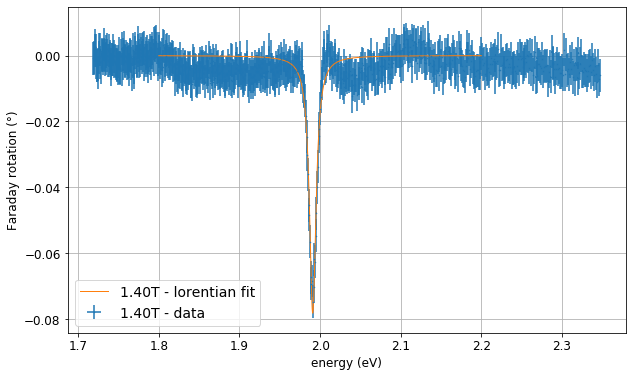

[1.9908351558123172+/-0.00038131657196613443
 -2.9906244917215975e-05+/-1.6502645882660018e-06
 0.009818184139831652+/-0.00036622240892963053]


In [12]:
#setup WS2 1.4T

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()

#Datenpunkte
plt.errorbar(unv(xdataWS2), unv(ydataWS2_1400mT), usd(ydataWS2_1400mT), usd(xdataWS2), label="1.40T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataWS2), unv(ydataWS2_1400mT), lorentz, yerr = usd(ydataWS2_1400mT), p0 = [1.9925,-0.01,0.005])
l6 = unp.uarray(pfit, perr)
xfit = np.linspace(1.8, 2.2, 1000)
yfit = lorentz(xfit, *unv(l6))
plt.plot(xfit, unv(yfit) , linewidth = 1, label="1.40T - lorentian fit")
min6 = min( lorentz(xfit, *unv(l6)) )
pos6 = l6[0]

# fig param

plt.grid()
plt.xlabel("energy (eV)")
plt.ylabel("Faraday rotation (°)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/WS2_1400mT.pdf")
plt.show()

print(l6)

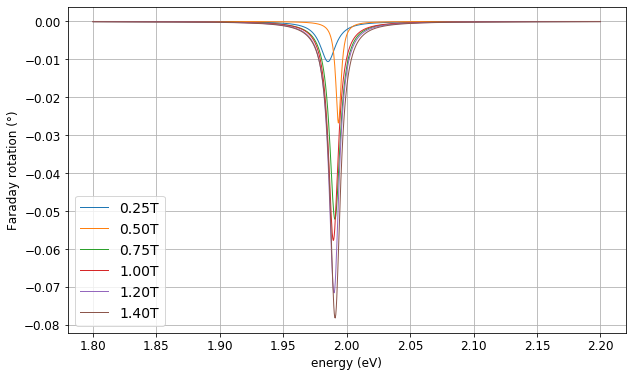

-0.07819725125637222
(1.9900+/-0.0010)e+00


In [13]:
# all lorentian fits

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()

#Datenpunkte

pos = [pos1,pos2,pos3,pos4,pos5,pos6]
xpos = sum(pos)/6.

plt.plot(xfit, unv(lorentz(xfit, *unv(l1))) , linewidth = 1, label="0.25T")
plt.plot(xfit, unv(lorentz(xfit, *unv(l2))) , linewidth = 1, label="0.50T")
plt.plot(xfit, unv(lorentz(xfit, *unv(l3))) , linewidth = 1, label="0.75T")
plt.plot(xfit, unv(lorentz(xfit, *unv(l4))) , linewidth = 1, label="1.00T")
plt.plot(xfit, unv(lorentz(xfit, *unv(l5))) , linewidth = 1, label="1.20T")
plt.plot(xfit, unv(lorentz(xfit, *unv(l6))) , linewidth = 1, label="1.40T")

# fig param

plt.grid()
plt.xlabel("energy (eV)")
plt.ylabel("Faraday rotation (°)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/WS2_lorentians.pdf")
plt.show()

print( min( lorentz(xfit, *unv(l6)) ) )

print("{:e}".format(xpos))

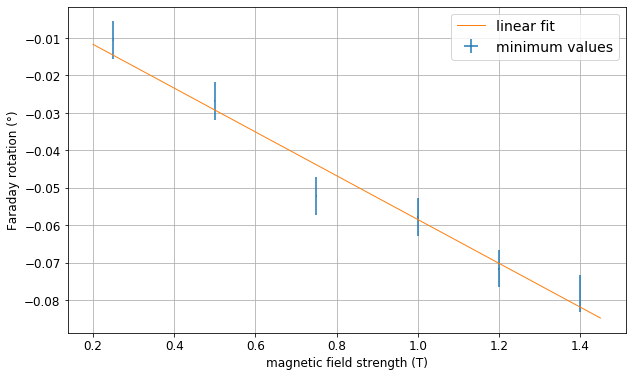

In [14]:
# all lorentian fits

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()

#Datenpunkte

b_error = 0.001
ys_error = [0.005,0.005,0.005,0.005,0.005,0.005]

bs = [0.25,0.50,0.75,1.00,1.20,1.40]
ys = [min1,min2,min3,min4,min5,min6]

plt.errorbar(bs, unv(ys), ys_error, b_error, label="minimum values", ls=" ")

pfit, perr = fit_curvefit(bs, unv(ys), linear, yerr = ys_error, p0 = [-0.04])
l1 = unp.uarray(pfit, perr)
xfit = np.linspace(0.2, 1.45, 1000)
yfit = linear(xfit, *unv(l1))
plt.plot(xfit, unv(yfit) , linewidth = 1, label="linear fit")

# fig param

plt.grid()
plt.xlabel("magnetic field strength (T)")
plt.ylabel("Faraday rotation (°)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/WS2_mins.pdf")
plt.show()

verdetWS2 = l1[0] # per sample thickness

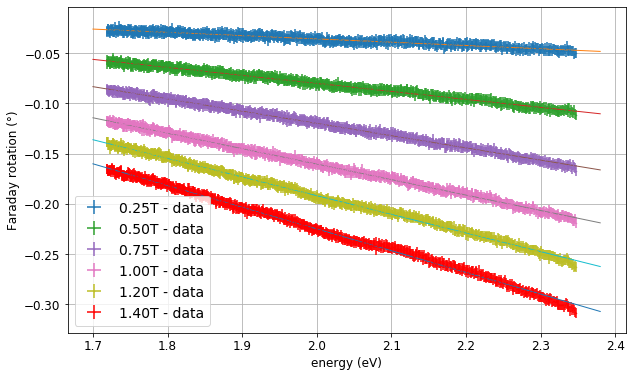

In [15]:
#setup Sapphire

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()


#Datenpunkte 250mT
plt.errorbar(unv(xdataSap), unv(ydataSap_250mT), usd(ydataSap_250mT), usd(xdataSap), label="0.25T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataSap), unv(ydataSap_250mT), gerade, yerr = usd(ydataSap_250mT), p0 = [-0.15,0.1])
l1 = unp.uarray(pfit, perr)
xfit = np.linspace(1.7, 2.38, 1000)
yfit = gerade(xfit, *unv(l1))
plt.plot(xfit, unv(yfit) , linewidth = 1)
slope1 = l1[0]


#Datenpunkte 500mT
plt.errorbar(unv(xdataSap), unv(ydataSap_500mT), usd(ydataSap_500mT), usd(xdataSap), label="0.50T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataSap), unv(ydataSap_500mT), gerade, yerr = usd(ydataSap_500mT), p0 = [-0.20,0.1])
l2 = unp.uarray(pfit, perr)
xfit = np.linspace(1.7, 2.38, 1000)
yfit = gerade(xfit, *unv(l2))
plt.plot(xfit, unv(yfit) , linewidth = 1)
slope2 = l2[0]


#Datenpunkte 750mT
plt.errorbar(unv(xdataSap), unv(ydataSap_750mT), usd(ydataSap_750mT), usd(xdataSap), label="0.75T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataSap), unv(ydataSap_750mT), gerade, yerr = usd(ydataSap_750mT), p0 = [-0.25,0.1])
l3 = unp.uarray(pfit, perr)
xfit = np.linspace(1.7, 2.38, 1000)
yfit = gerade(xfit, *unv(l3))
plt.plot(xfit, unv(yfit) , linewidth = 1)
slope3 = l3[0]


#Datenpunkte 1000mT
plt.errorbar(unv(xdataSap), unv(ydataSap_1000mT), usd(ydataSap_1000mT), usd(xdataSap), label="1.00T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataSap), unv(ydataSap_1000mT), gerade, yerr = usd(ydataSap_1000mT), p0 = [-0.30,0.1])
l4 = unp.uarray(pfit, perr)
xfit = np.linspace(1.7, 2.38, 1000)
yfit = gerade(xfit, *unv(l4))
plt.plot(xfit, unv(yfit) , linewidth = 1)
slope4 = l4[0]


#Datenpunkte 1200mT
plt.errorbar(unv(xdataSap), unv(ydataSap_1200mT), usd(ydataSap_1200mT), usd(xdataSap), label="1.20T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataSap), unv(ydataSap_1200mT), gerade, yerr = usd(ydataSap_1200mT), p0 = [-0.35,0.1])
l5 = unp.uarray(pfit, perr)
xfit = np.linspace(1.7, 2.38, 1000)
yfit = gerade(xfit, *unv(l5))
plt.plot(xfit, unv(yfit) , linewidth = 1)
slope5 = l5[0]


#Datenpunkte 1400mT
plt.errorbar(unv(xdataSap), unv(ydataSap_1400mT), usd(ydataSap_1400mT), usd(xdataSap), label="1.40T - data",color ="r", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataSap), unv(ydataSap_1400mT), gerade, yerr = usd(ydataSap_1400mT), p0 = [-0.40,0.1])
l6 = unp.uarray(pfit, perr)
xfit = np.linspace(1.7, 2.38, 1000)
yfit = gerade(xfit, *unv(l6))
plt.plot(xfit, unv(yfit) , linewidth = 1)
slope6 = l6[0]

# fig param

plt.grid()
plt.xlabel("energy (eV)")
plt.ylabel("Faraday rotation (°)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/sapphire_lins.pdf")
plt.show()

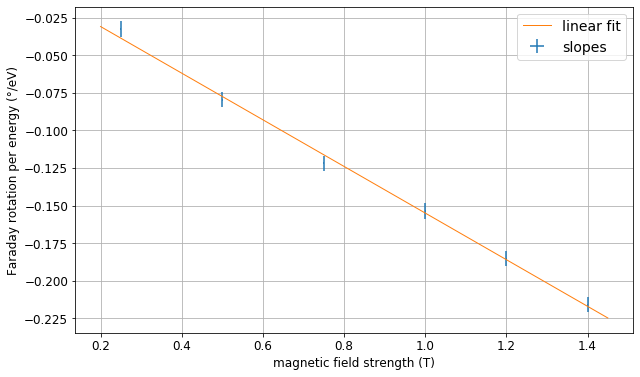

In [16]:
# all lorentian fits

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()

#Datenpunkte

b_error = 0.001
ys_error = [0.005,0.005,0.005,0.005,0.005,0.005]

bs = [0.25,0.50,0.75,1.00,1.20,1.40]
ys = [slope1,slope2,slope3,slope4,slope5,slope6]

plt.errorbar(bs, unv(ys), ys_error, b_error, label="slopes", ls=" ")

pfit, perr = fit_curvefit(bs, unv(ys), linear, yerr = ys_error, p0 = [-0.04])
l1 = unp.uarray(pfit, perr)
xfit = np.linspace(0.2, 1.45, 1000)
yfit = linear(xfit, *unv(l1))
plt.plot(xfit, unv(yfit) , linewidth = 1, label="linear fit")

# fig param

plt.grid()
plt.xlabel("magnetic field strength (T)")
plt.ylabel("Faraday rotation per energy (°/eV)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/sapphire_slopes.pdf")
plt.show()

verdetSapp = l1[0] # per sample thickness

In [17]:
# verdet constants:

print("{:e}".format(1e10 * verdetWS2 / 6.5))
print("{:e}".format(1e4 * verdetSapp / 5))
print("{:e}".format(1e4 * verdetSapp * xpos / 5))

# in deg per m  per T

(-8.99+/-0.31)e+07
(-3.100+/-0.034)e+02
(-6.17+/-0.07)e+02


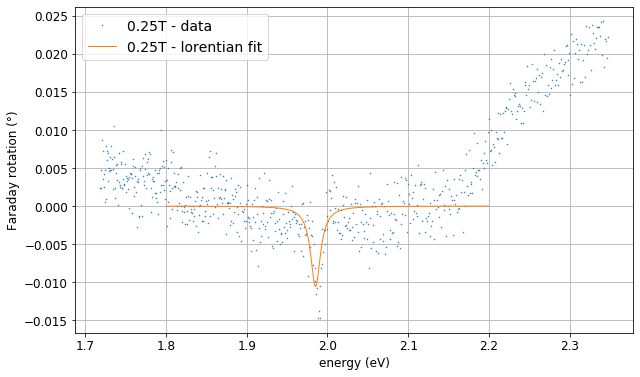

[1.9852333873557984+/-0.005123385034997739
 -9.29667840122089e-06+/-6.247675853417735e-06
 0.014929355346873827+/-0.007105897774836125]


In [18]:
#setup WS2 0.25T

fig=plt.figure(figsize=fullscreen)
ax = plt.gca()

#Datenpunkte
plt.plot(unv(xdataWS2), unv(ydataWS2_250mT), label="0.25T - data", ls=" ", marker=".", markersize = 1)

pfit, perr = fit_curvefit(unv(xdataWS2), unv(ydataWS2_250mT), lorentz, yerr = usd(ydataWS2_250mT), p0 = [2.02,-0.02,0.005])
l1 = unp.uarray(pfit, perr)
xfit = np.linspace(1.8, 2.2, 1000)
yfit = lorentz(xfit, *unv(l1))
plt.plot(xfit, unv(yfit) , linewidth = 1, label="0.25T - lorentian fit")
min1 = min( lorentz(xfit, *unv(l1)) )
pos1 = l1[0]

# fig param

plt.grid()
plt.xlabel("energy (eV)")
plt.ylabel("Faraday rotation (°)")
plt.legend(prop={'size':fig_legendsize})
plt.tick_params(labelsize=fig_labelsize)
plt.savefig("../plots/WS2_250mT_noerror.pdf")
plt.show()

print(l1)